# Заполнение submit Вариант с нормированными столбцами

In [68]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [69]:
fl_train=pd.read_csv('HW/train.csv')
fl_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24712 entries, 0 to 24711
Data columns (total 22 columns):
_id               24712 non-null object
age               24712 non-null int64
job               24712 non-null object
marital           24712 non-null object
education         24712 non-null object
default           24712 non-null object
housing           24712 non-null object
loan              24712 non-null object
contact           24712 non-null object
month             24712 non-null object
day_of_week       24712 non-null object
duration          24712 non-null int64
campaign          24712 non-null int64
pdays             24712 non-null int64
previous          24712 non-null int64
poutcome          24712 non-null object
emp.var.rate      24712 non-null float64
cons.price.idx    24712 non-null float64
cons.conf.idx     24712 non-null float64
euribor3m         24712 non-null float64
nr.employed       24712 non-null float64
target            24712 non-null int64
dtypes: floa

# Подготовка данных

In [70]:
# Удаляем id И target
train= fl_train.drop(['_id', 'target'], axis=1)
#train= train.drop('euribor3m', axis=1)
y = fl_train.target

In [71]:
num_list=train.select_dtypes(include=[np.number]).columns.tolist()

In [72]:
# Так как в даной задаче мы имеем данные, на которых будет проверяться, то для логарифмов лучше сразу учесть диапазон.
fl_test=pd.read_csv('HW/test.csv')
test= fl_test.drop(['_id'], axis=1)

In [73]:
# Расширим данные квадратами и логарифмами
num_list_2=[]
num_list_lg=[] 
a=2
for i,col in enumerate(num_list) :

    new_col=col + '_2'
    train[new_col]=train[col].map(lambda x: x**a)
    num_list_2.append(new_col)

    new_col=col + '_lg'
    x_min=min(train[col].min(),test[col].min())
    train[new_col]=train[col].map(lambda x: np.log2(x-x_min+1))
    num_list_lg.append(new_col)

train.columns.shape

(40,)

In [74]:
# Отнормируем числовый столбцы. Запомним метрики, чтобы тестовый файл потом нормировать теми же величинами

num_metrics=pd.DataFrame(columns=['col','mean','std'])
for i,col in enumerate(num_list+num_list_2+num_list_lg) :

    mean=train[col].mean()
    std=train[col].std()
    num_metrics.loc[i]=[col,mean,std]

    train[col]=train[col].map(lambda x : (x-mean)/std)

#num_metrics

In [75]:
# Ванинкодим по чёрному
train=pd.get_dummies(train)

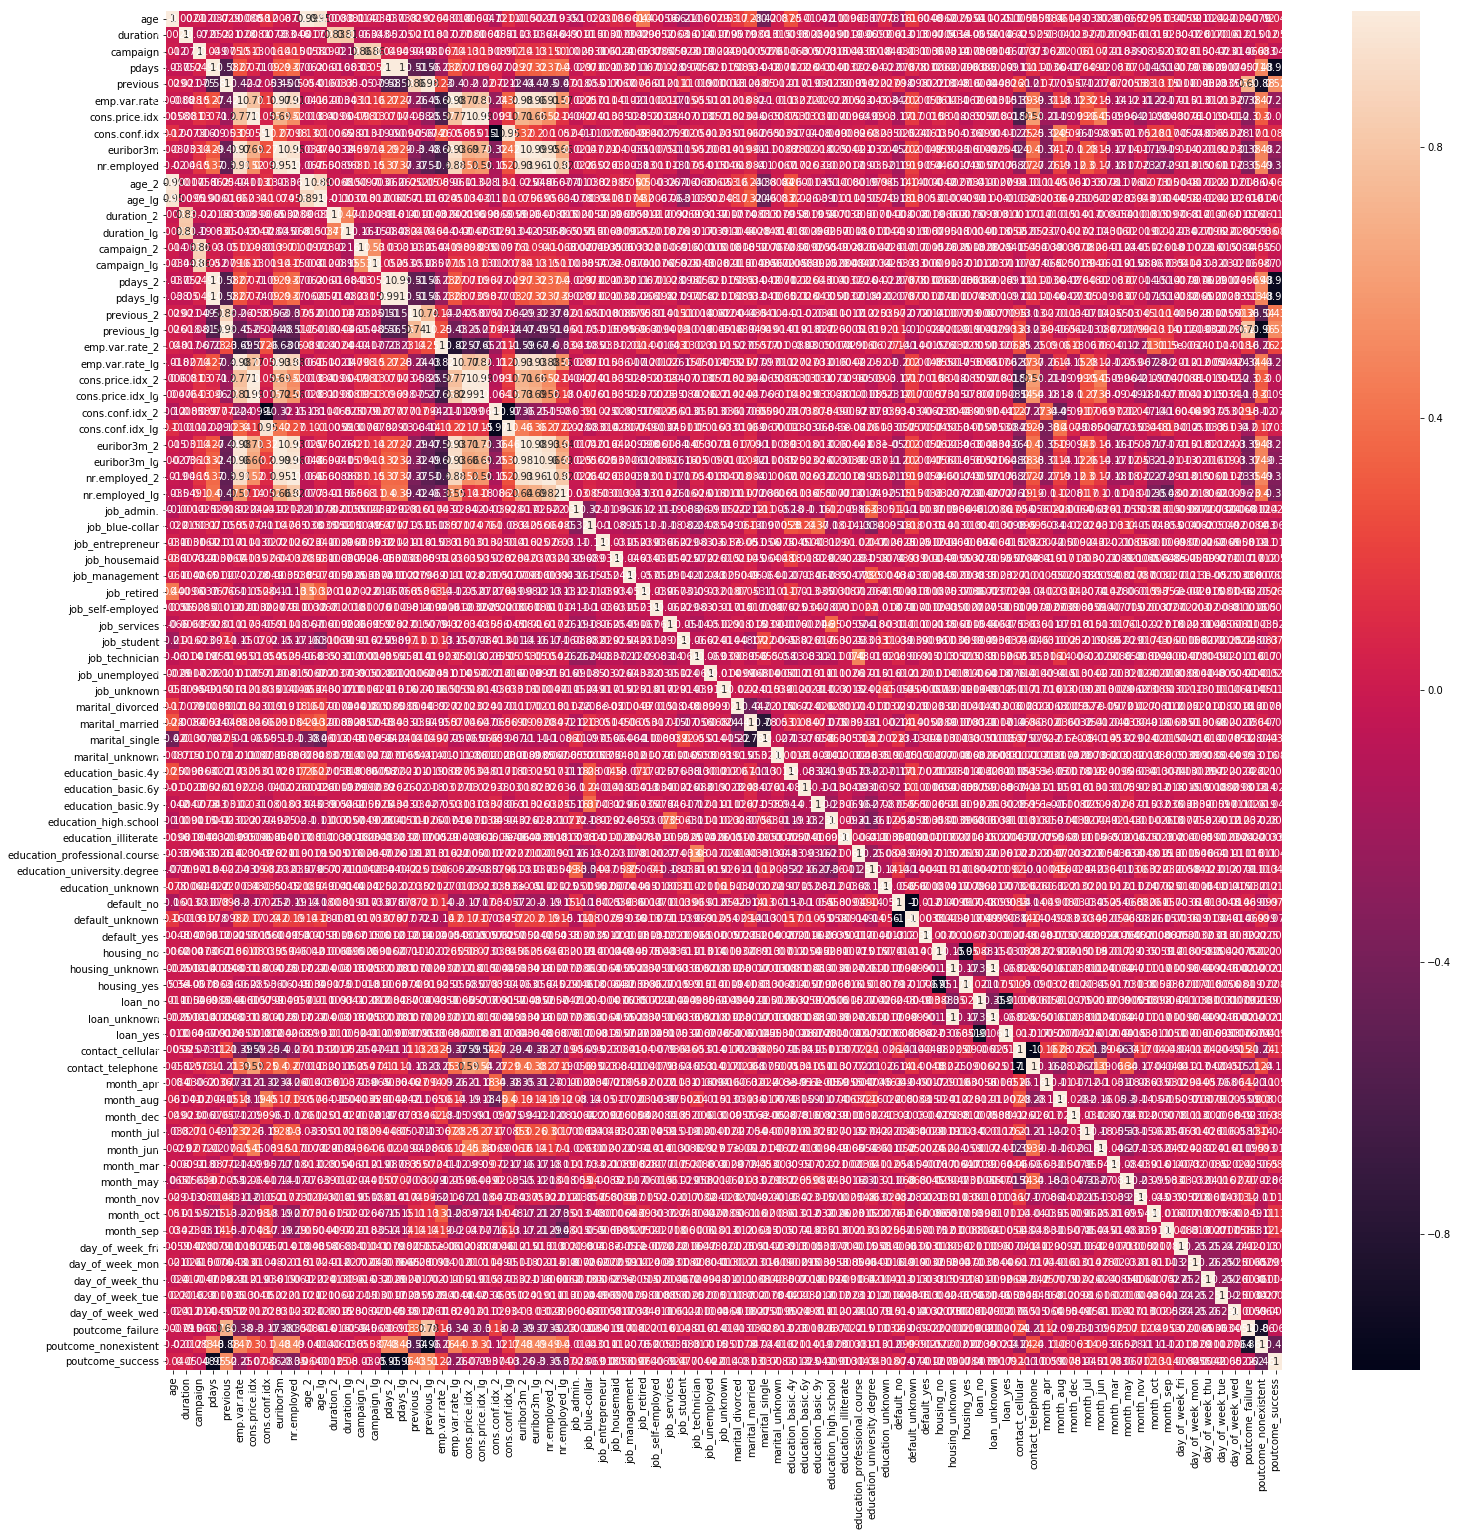

In [76]:
# Посмотрим корреляции
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(train.corr(), annot=True)

In [77]:
# Дропнем все 'unknown', так как они однозначно определяется через остальные колонки
for i in train.columns:
    if 'unknown' in i:
        train=train.drop(i, axis=1)

# Обучение

In [78]:
X_train=train
y_train=y

In [79]:
# Путём переборов определили, что самый хороший результата на LogisticRegression(penalty='l1')
lr = LogisticRegression(penalty='l1')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Проверка результата

In [80]:
a=30
print('Средний на кросс-валидации по {} разбиениям train-файла'.format(a))
cv = StratifiedKFold(n_splits=a, shuffle=True, random_state=15)
cvc_lr=cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=cv.split(X_train, y_train) )
print('lr', cvc_lr.mean())

Средний на кросс-валидации по 30 разбиениям train-файла
lr 0.9389656155163293


# Получаем данные на submit

In [81]:
fl_test=pd.read_csv('HW/test.csv')
fl_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16476 entries, 0 to 16475
Data columns (total 21 columns):
_id               16476 non-null object
age               16476 non-null int64
job               16476 non-null object
marital           16476 non-null object
education         16476 non-null object
default           16476 non-null object
housing           16476 non-null object
loan              16476 non-null object
contact           16476 non-null object
month             16476 non-null object
day_of_week       16476 non-null object
duration          16476 non-null int64
campaign          16476 non-null int64
pdays             16476 non-null int64
previous          16476 non-null int64
poutcome          16476 non-null object
emp.var.rate      16476 non-null float64
cons.price.idx    16476 non-null float64
cons.conf.idx     16476 non-null float64
euribor3m         16476 non-null float64
nr.employed       16476 non-null float64
dtypes: float64(5), int64(5), object(11)
memory usa

# Чистим их также как в train

In [82]:
# Удаляем id
test= fl_test.drop(['_id'], axis=1)
#test.columns.shape

In [83]:
a=2
for i,col in enumerate(num_list) :

    new_col=col+'_2'
    test[new_col]=test[col].map(lambda x: x**a)

    new_col=col+'_lg'
    x_min=min(test[col].min(),fl_train[col].min())
    test[new_col]=test[col].map(lambda x: np.log2(x-x_min+1))
#test.columns.shape

In [84]:
# Отнормируем числовый столбцы (по метрикам, полученным на train)
for i, col in enumerate(num_metrics.col):
    if col in test.columns:
        mean=num_metrics.loc[i,'mean']
        std=num_metrics.loc[i,'std']
        test[col]=test[col].map(lambda x : (x-mean)/std)

In [85]:
test=pd.get_dummies(test)
test.columns.shape

(83,)

In [86]:
# Дропнем все 'unknown', так как они однозначно определяется через остальные колонки
for i in test.columns:
    if 'unknown' in i:
        test=test.drop(i, axis=1)

In [88]:
y_subm=lr.predict_proba(test)[:,1]

In [89]:
np.shape(y_subm)

(16476,)

In [90]:
fl_subm=pd.read_csv('HW/sample_submission.csv')

In [91]:
fl_subm['target'] = y_subm

In [92]:
new_submit_file='my_subm12.csv'
fl_subm.to_csv(new_submit_file, index=False)

In [94]:
subm_final=pd.read_csv(new_submit_file)
subm_final

,_id,target
0,66810d8e6bf2b41c880a7bc6c8a1e295,0.079457
1,ccac3879652b08cb8b44c1920fd93afa,0.012332
2,fcccab4d7a76f70647f015f2c84c2af8,0.002008
3,ed8399278c30678dab739045fa12b440,0.051770
4,1d4d62ac5cabcb48bac7112813f290cb,0.015392
5,aba2dec4c5cab88824f36babd24b986f,0.222412
6,06f318f1dd178e738f675bb88a5adb84,0.008703
7,d5036f5956e42ee6207296238fc4bc1d,0.000517
8,fe0cc8933698ad4046ff2b82f65756eb,0.010426
9,70190122f4ebf196535e11b33eb95b81,0.001183
